### Deep learning model training.


In [4]:
import time
import torch
import random
import pandas as pd
import torch.nn as nn
from glob import glob
import geopandas as gpd
from notebooks import config
from torchinfo import summary
from utils.imgShow import imsShow
from utils.utils import read_scenes
from utils.metrics import oa_binary, miou_binary
from utils.dataloader import SceneArraySet, PatchPathSet
from model import unet, deeplabv3plus, deeplabv3plus_mobilev2, u2net


In [2]:
patch_size = 512  ## patch size setting
# ## traset
paths_scene_tra, paths_dem_tra, paths_truth_tra = config.paths_scene_tra, config.paths_dem_tra, config.paths_truth_tra
print(f'train scenes: {len(paths_scene_tra)}')
## valset
paths_patch_valset = sorted(glob('data/dset/valset/patch_'+str(patch_size)+'/*'))
print(f'vali patch: {len(paths_patch_valset)}')


train scenes: 48
vali patch: 275


### dataset loading

In [3]:
scenes_arr, truths_arr = read_scenes(paths_scene_tra, 
                                     paths_truth_tra, 
                                     paths_dem_tra) 


In [4]:
## Create dataset instances
tra_data = SceneArraySet(scenes_arr=scenes_arr, 
                         truths_arr=truths_arr, 
                         path_size=(patch_size, patch_size))
val_data = PatchPathSet(paths_valset=paths_patch_valset)
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=10)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=4)


#### Model training

In [5]:
### check model
model = unet(num_bands=7)
# model = deeplabv3plus(num_bands=7)
# model = deeplabv3plus_mobilev2(num_bands=7)
summary(model, input_size=(1,7,256,256), device='cpu')


Layer (type:depth-idx)                   Output Shape              Param #
unet                                     [1, 1, 256, 256]          --
├─Sequential: 1-1                        [1, 16, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 16, 256, 256]         1,024
│    └─BatchNorm2d: 2-2                  [1, 16, 256, 256]         32
│    └─ReLU: 2-3                         [1, 16, 256, 256]         --
├─Sequential: 1-2                        [1, 32, 128, 128]         --
│    └─Conv2d: 2-4                       [1, 32, 128, 128]         4,640
│    └─BatchNorm2d: 2-5                  [1, 32, 128, 128]         64
│    └─ReLU: 2-6                         [1, 32, 128, 128]         --
├─Sequential: 1-3                        [1, 64, 64, 64]           --
│    └─Conv2d: 2-7                       [1, 64, 64, 64]           18,496
│    └─BatchNorm2d: 2-8                  [1, 64, 64, 64]           128
│    └─ReLU: 2-9                         [1, 64, 64, 64]           --
├─Se

In [6]:
### create loss and optimizer
loss_bce = nn.BCELoss()     
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, \
                                          mode='min', factor=0.6, patience=20)

In [9]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x.float())
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model, loss_fn, optimizer, 
                    tra_loader, val_loader, epoches, 
                    device, lr_scheduler=None):
    tra_loss_loops, tra_miou_loops, tra_oa_loops = [], [], []
    val_loss_loops, val_miou_loops, val_oa_loops = [], [], []
    model = model.to(device)
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                    optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        if lr_scheduler:
          lr_scheduler.step(tra_loss)    # if using ReduceLROnPlateau
        '''-----validation the model-----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                                    x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss), tra_miou_loops.append(tra_miou), tra_oa_loops.append(tra_oa)
        val_loss_loops.append(val_loss), val_miou_loops.append(val_miou), val_oa_loops.append(val_oa)
        print(f'Ep{epoch+1}: tra-> Loss:{tra_loss:.3f},Oa:{tra_oa:.2f},Miou:{tra_miou:.2f}, '
            f'val-> Loss:{val_loss:.2f},Oa:{val_oa:.2f},Miou:{val_miou:.2f},time:{time.time()-start:.0f}s')
        ## show the result
        if (epoch+1)%20 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, truth = val_data[sam_index]
            patch, truth = torch.unsqueeze(patch.float(), 0).to(device), truth.to(device)
            pred = model(patch)
            ## convert to numpy and plot
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pdem = patch[:,:, -1]
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            imsShow([patch, pdem, truth, pred], 
                    clip_list = (2,2,0,0),
                    img_name_list=['input_patch', 'pdem', 'truth', 'prediction'], 
                    
                    figsize=(13,3))
    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'tra_oa': tra_oa_loops, 
                'val_loss': val_loss_loops, 'val_miou': val_miou_loops, 'val_oa': val_oa_loops}
    return metrics 


Ep1: tra-> Loss:0.103,Oa:0.92,Miou:0.89, val-> Loss:0.15,Oa:0.92,Miou:0.84,time:3s
Ep2: tra-> Loss:0.141,Oa:0.92,Miou:0.85, val-> Loss:0.16,Oa:0.92,Miou:0.84,time:3s
Ep3: tra-> Loss:0.078,Oa:0.95,Miou:0.92, val-> Loss:0.16,Oa:0.92,Miou:0.84,time:3s
Ep4: tra-> Loss:0.087,Oa:0.95,Miou:0.90, val-> Loss:0.17,Oa:0.92,Miou:0.84,time:3s
Ep5: tra-> Loss:0.118,Oa:0.93,Miou:0.90, val-> Loss:0.16,Oa:0.92,Miou:0.83,time:3s
Ep6: tra-> Loss:0.114,Oa:0.90,Miou:0.83, val-> Loss:0.19,Oa:0.92,Miou:0.82,time:3s
Ep7: tra-> Loss:0.073,Oa:0.95,Miou:0.92, val-> Loss:0.15,Oa:0.92,Miou:0.84,time:3s
Ep8: tra-> Loss:0.112,Oa:0.93,Miou:0.89, val-> Loss:0.15,Oa:0.92,Miou:0.84,time:3s
Ep9: tra-> Loss:0.081,Oa:0.97,Miou:0.94, val-> Loss:0.15,Oa:0.92,Miou:0.84,time:3s
Ep10: tra-> Loss:0.084,Oa:0.95,Miou:0.92, val-> Loss:0.15,Oa:0.92,Miou:0.84,time:3s
Ep11: tra-> Loss:0.080,Oa:0.90,Miou:0.86, val-> Loss:0.15,Oa:0.92,Miou:0.84,time:3s
Ep12: tra-> Loss:0.083,Oa:0.94,Miou:0.90, val-> Loss:0.16,Oa:0.93,Miou:0.84,time:3s
E

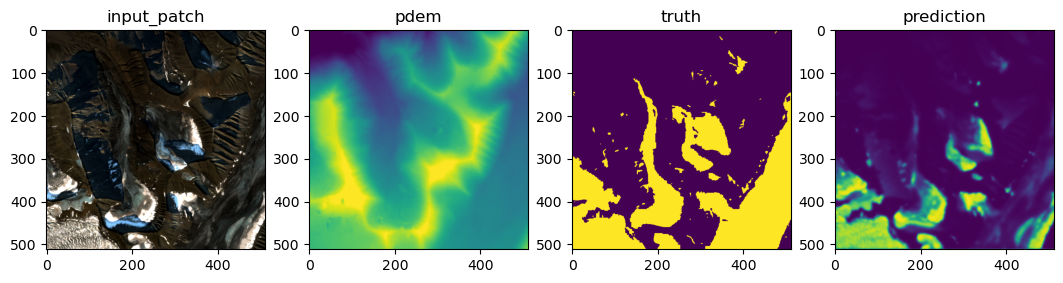

In [10]:
device = torch.device('cuda:0') 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metrics = train_loops(model=model, 
                epoches=20,  
                loss_fn=loss_bce,  
                optimizer=optimizer,  
                tra_loader=tra_loader,    
                val_loader=val_loader,  
                lr_scheduler=lr_scheduler,
                device=device)     


In [ ]:
# ## model saving
# net_name = 'unet'
# # net_name = 'deeplabv3plus'
# net_name = 'deeplabv3plus_mobilev2'
# # net_name = 'hrnet'
# path_save = f'model/trained/{net_name}.pth'
# torch.save(model.state_dict(), path_save)   ## save weights of the trained model 
# model.load_state_dict(torch.load(path_save, weights_only=True))  # load the weights of the trained model
# ## metrics saving
# path_metrics = f'model/trained/{net_name}_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(path_metrics, index=False, sep=',')

